Notebook to create ESG index for sectors and industries. It also subtracts shifts.

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import invgamma
import datetime
import scipy
import importlib
import os, sys
sys.path.insert(0, 'C:/Users/ragna/Documents/Code/MMDGraph')#C:\Users\ragna\Documents\Code\MMDGraph
import Gibbs
import seaborn as sns
import tqdm
from pandas_datareader import data

In [67]:
def index_esg_industry(sector, asset_profiles, esg_data, marketcap):
    
    industries = np.unique(asset_profiles['industry'].loc[asset_profiles['sector'] == sector])

    k = len(industries)

    
    index_dict = dict()
    for industry in industries:
        companies_in_industry = np.array(list(asset_profiles['ticker'].loc[asset_profiles['industry'] == industry]))
        companies_in_industry = companies_in_industry[np.isin(companies_in_industry, esg_data.columns)]
        # print(f'{industry} {companies_in_industry}')


        

        index_dict[industry] = np.zeros(esg_data.shape[0])

        market_cap_sum = np.sum(marketcap.loc[np.isin(marketcap['ticker'], companies_in_industry), 'marketcap'])
            
        for ticker in companies_in_industry:

            
            tmp = np.array(esg_data[ticker])
            tmp[np.isnan(esg_data[ticker])] = 0

            index_dict[industry] = index_dict[industry] + tmp*marketcap.loc[marketcap['ticker'] == ticker, 'marketcap'][0]/market_cap_sum

            # if the index is zero, all esg scores are nan
            index_dict[industry][index_dict[industry] == 0] = np.nan



    index_dict = pd.DataFrame(index_dict)
    index_dict.index = esg_data.index.copy()

    return index_dict





def plot_esg_industry(sector, asset_profiles, esg_data):
    industries = np.unique(asset_profiles['industry'].loc[asset_profiles['sector'] == sector])

    k = len(industries)

    fig, axs = plt.subplots( int(k/4)+1 , 4, figsize = (40 ,5*(int(k/4)+1)))
        

    for idx, industry in enumerate(industries):

        j = idx % 4
        i = int(np.floor(idx/4)) 
        
        companies_in_industry = list(asset_profiles['ticker'].loc[asset_profiles['industry'] == industry])
        axs[i,j].set_title(industry)
        if np.sum(esg_data.columns.isin(companies_in_industry)) == 0:
            print(f'No esg data on companies in industry {industry}')
            continue
        companies = esg_data.loc[:, esg_data.columns.isin(companies_in_industry)]

        for ticker in companies.columns:
            
            y = esg_data[ticker]
            ymask = np.isfinite(y)
            x = esg_data.index[ymask]
            axs[i,j].plot(x, y[ymask], alpha = 0.4)

def find_jump(y):
    """
    Returns
    -------------------------
    jump_index - index when jump occurs
    jump_index_prev - number of observation (nan not included) before jump
    biggest_jump_direction - size of the jump and direction (minus is jump down)


    
    """

    biggest_jump = 0
    biggest_jump_direction = 0
    prev_value = y[0,0]  # previous non nan value
    jump_index = 0
    jump_index_prev = 0

    observations = [0]
    for i in range(1,y.shape[0]):

        if np.isnan(y[i,0]):
            continue

        observations.append(i)


        this_jump = np.abs(y[i,0] - prev_value)
        this_jump_direction = y[i,0] - prev_value
        if this_jump > biggest_jump:
            biggest_jump = this_jump
            biggest_jump_direction = this_jump_direction
            jump_index_prev = observations[-2]
            jump_index = i

        prev_value = y[i,0]

    return jump_index, jump_index_prev, biggest_jump_direction

# Read data

In [68]:
PRICE = pd.read_csv("../Yahoo/YAHOO_PRICE.csv")
ESG_data = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'ESG')
TICKERS = np.unique(ESG_data['ticker'])
companies = np.unique(PRICE['ticker']) 
asset_profiles = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'asset_profiles') 


esg_series = ESG_data.copy()  #ESG_data.loc[ESG_data['ticker'] == 'BMY'].copy()
esg_series['timestamp'] = pd.to_datetime(esg_series['timestamp'])
min_date = datetime.datetime(2014,10, 1)
max_date = np.max(ESG_data['timestamp'])
esg_series['date'] = esg_series['timestamp'].dt.date
print(min_date)
print(max_date)
esg_series


# Create a series of days, which will then be joined with esg_series, To create "daily" ESG.
dates = pd.DataFrame({'date':pd.date_range(min_date,max_date,freq='d')})
dates['date'] = dates['date'].dt.date

# create an esg data frame where index is monthly
esg_pivot = esg_series[['ticker', 'esgScore', 'date']].copy()
esg_pivot_diff =pd.pivot_table(esg_pivot, values = 'esgScore', index = 'date', columns= 'ticker').diff().iloc[1:]#  np.log(pd.pivot_table(esg_pivot, values = 'esgScore', index = 'date', columns= 'ticker').pct_change().iloc[1:] + 1)
esg_pivot = pd.pivot_table(esg_pivot, values = 'esgScore', index = 'date', columns= 'ticker')
esg_pivot = pd.merge(dates, esg_pivot, how = 'left', left_on='date', right_index=True)
esg_pivot_diff = pd.merge(dates, esg_pivot_diff, how = 'left', left_on='date', right_index=True)
esg_pivot.set_index('date', inplace= True)
esg_pivot_diff.set_index('date', inplace= True)
esg_pivot = esg_pivot.loc[:, esg_pivot.count() >20]  # remove observations with lass than 10 observations
esg_pivot_diff = esg_pivot_diff.loc[:, esg_pivot_diff.count() >20]



asset_profiles = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'asset_profiles') 

esg_pivot_enough_data = esg_pivot.loc[:,~np.isnan(esg_pivot.iloc[0,:])]
sector_classification = dict()
for company in esg_pivot_enough_data.columns:
    sector_of_company = asset_profiles['sector'].loc[asset_profiles['ticker'] == company].iloc[0]
    if sector_of_company not in sector_classification.keys():
        sector_classification[sector_of_company] = list()
    sector_classification[sector_of_company].append(company)

esg_pivot



2014-10-01 00:00:00
2022-02-01 00:00:00


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2014-10-01,71.00,73.00,48.00,60.00,62.00,55.00,64.00,72.00,70.00,64.00,...,77.00,50.0,71.0,65.00,57.00,64.00,58.00,61.00,47.0,47.00
2014-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
np.max(esg_pivot_diff.count())

75

In [69]:
for k,v in sector_classification.items():
    print(f'{k} {len(v)}')

Healthcare 51
Industrials 61
Consumer Cyclical 52
Technology 53
Consumer Defensive 32
Utilities 27
Financial Services 58
Basic Materials 17
Real Estate 27
Energy 18
Communication Services 17


# Single company data frame

Plot some examples

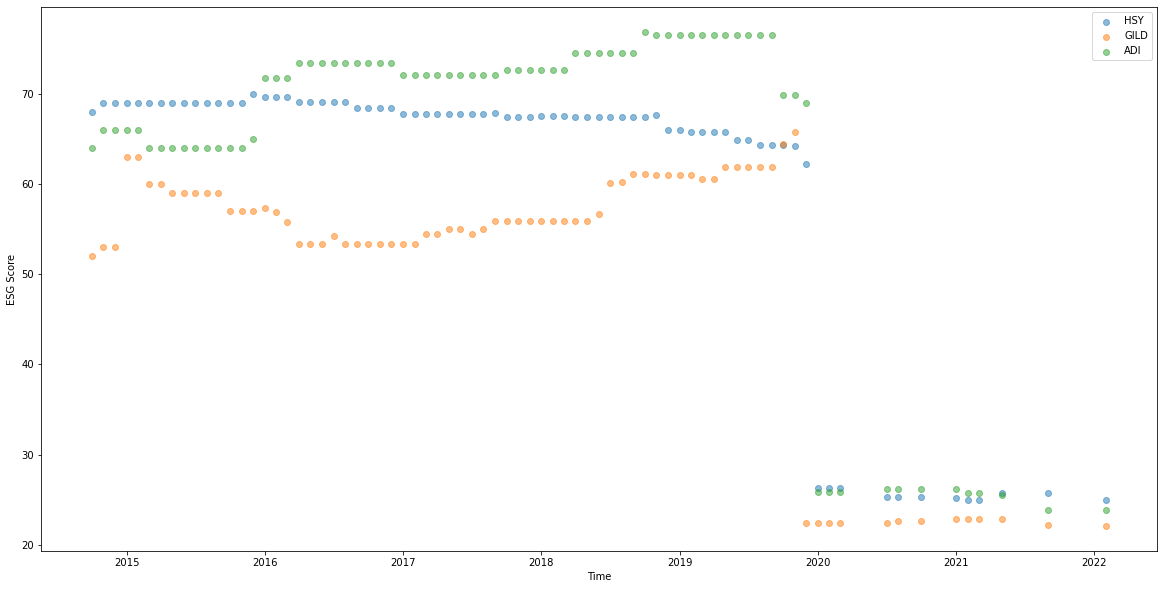

In [157]:
fig, ax = plt.subplots(1,1, figsize = (20,10))

for i, stock in enumerate(['HSY', 'GILD', 'ADI']):
    ax.scatter(esg_pivot.index, esg_pivot.loc[:,stock], alpha = 0.5, label = stock)
    ax.set_ylabel("ESG Score")
    ax.set_xlabel("Time")

ax.legend()

Subtract the shift of each series by subtracting the mean before and after for each series

In [160]:
esg_pivot_shifted = esg_pivot.copy()

for stock in esg_pivot.columns:
    y_tmp = np.expand_dims(esg_pivot.loc[:,stock], axis = 1)  # the function assumes 2 dimensional array
    index, _, _ = find_jump(y_tmp)
    esg_pivot_shifted[stock].iloc[:index] = np.nanmedian(esg_pivot[stock].iloc[index:]) - np.nanmedian(esg_pivot[stock].iloc[:index]) + esg_pivot[stock].iloc[:index]


Visualize changes

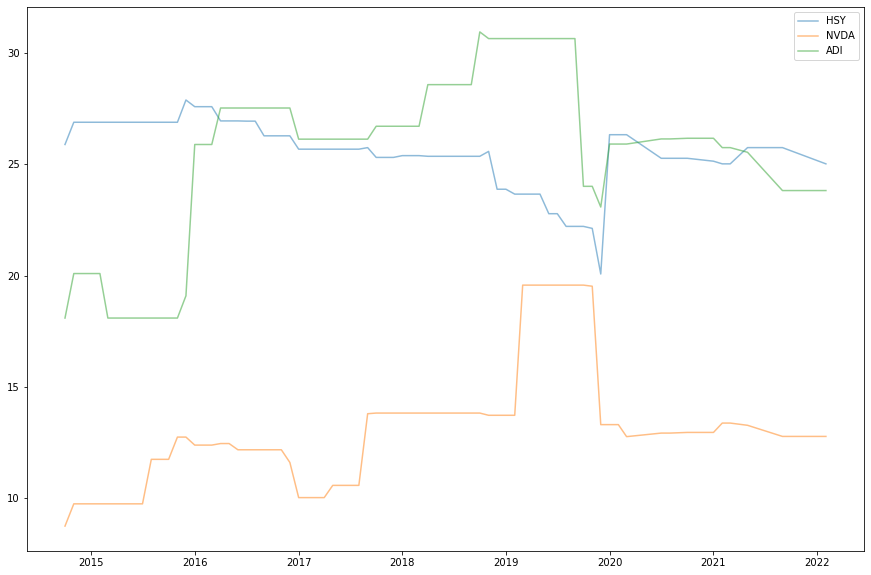

In [159]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
legend_ticks = []
for ticker in ['HSY', 'NVDA', 'ADI']:
    x = np.array(esg_pivot_shifted.index)
    y = np.array(esg_pivot_shifted[ticker])
    ymask = np.isfinite(y)
    out = ax.plot(x[ymask], y[ymask], alpha = 0.5)
    legend_ticks.append(ticker)

plt.legend(legend_ticks)

Calculate difference of shifted series and save

In [154]:
esg_pivot_shifted_refined_diff = []
for i in range(esg_pivot_shifted.shape[1]):
    diff = esg_pivot_shifted.iloc[:,i].dropna().diff().iloc[1:]
    esg_pivot_shifted_refined_diff.append(diff)

esg_pivot_shifted_refined_diff = pd.merge(pd.DataFrame(index = esg_pivot_shifted.index[esg_pivot_shifted.index >= datetime.date(2014,11, 1)])
,pd.concat(esg_pivot_shifted_refined_diff, axis = 1), left_index = True, right_index = True, how = 'left')

Visualize and save

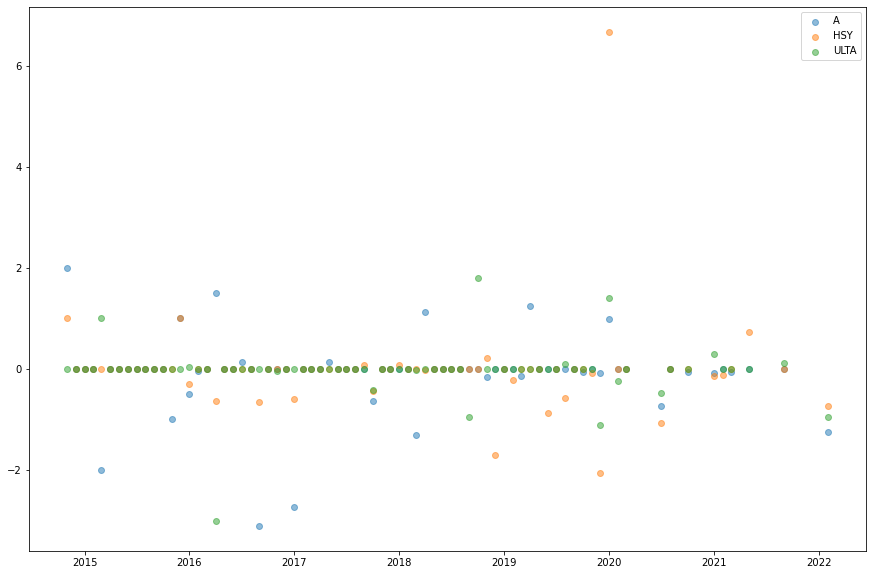

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
legend_ticks = []
for ticker in esg_pivot_shifted.columns[::200]:
    x = np.array(esg_pivot_shifted_refined_diff.index)
    y = np.array(esg_pivot_shifted_refined_diff[ticker])
    ymask = np.isfinite(y)
    out = ax.scatter(x[ymask], y[ymask], alpha = 0.5)
    legend_ticks.append(ticker)

plt.legend(legend_ticks)

In [76]:
esg_pivot_shifted_refined_diff.to_pickle('../Yahoo/refined.pkl')
esg_pivot_shifted.to_pickle('../Yahoo/refined_no_diff.pkl')

with pd.ExcelWriter('../Yahoo/ESG_companies.xlsx') as writer:  

    esg_pivot_shifted_refined_diff.to_excel(writer, sheet_name='Differenced')
    esg_pivot_shifted.to_excel(writer, sheet_name='No_diff')

# Sector index

Create an index for each sector by weighting ESG scores with market cap

In [145]:
# for loop to see which company fails
marketcap = pd.DataFrame()
for ticker in list(esg_pivot_shifted_refined_diff.columns):
    try:
        tmp_mcap = data.get_quote_yahoo(ticker)['marketCap']
        # print(tmp_mcap)
        marketcap  = pd.concat([marketcap, pd.DataFrame({"ticker":ticker, "marketcap":tmp_mcap[0]/1000_000}, index=[0])], ignore_index = True)
    except:
        print(f"{ticker} failed") 


A    36638760960
Name: marketCap, dtype: int64
AAL    13066832896
Name: marketCap, dtype: int64
AAP    13617752064
Name: marketCap, dtype: int64
AAPL    2654391238656
Name: marketCap, dtype: int64
ABBV    274003722240
Name: marketCap, dtype: int64
ABC    33093146624
Name: marketCap, dtype: int64
ABT    211558219776
Name: marketCap, dtype: int64
ACN    196583784448
Name: marketCap, dtype: int64
ADBE    194445197312
Name: marketCap, dtype: int64
ADI    81557635072
Name: marketCap, dtype: int64
ADM    51569274880
Name: marketCap, dtype: int64
ADP    94187757568
Name: marketCap, dtype: int64
ADSK    41203138560
Name: marketCap, dtype: int64
AEE    24956868608
Name: marketCap, dtype: int64
AEP    49763098624
Name: marketCap, dtype: int64
AES    14994397184
Name: marketCap, dtype: int64
AFL    41921028096
Name: marketCap, dtype: int64
AIG    50183208960
Name: marketCap, dtype: int64
AIZ    10630142976
Name: marketCap, dtype: int64
AJG    36901703680
Name: marketCap, dtype: int64
AKAM    1903

In [18]:
np.sum(~np.isnan(esg_pivot_shifted_refined_diff['DISCA']))

74

In [78]:
# add manually for failed
marketcap = pd.concat([marketcap, pd.DataFrame({"ticker":'SBUX', "marketcap":89.63*1000_000_000/1000_000}, index=[0])] )
marketcap = pd.concat([marketcap, pd.DataFrame({"ticker":'V', "marketcap":450.80*1000_000_000/1000_000}, index=[0])] )
marketcap = pd.concat([marketcap, pd.DataFrame({"ticker":'V', "marketcap":450.80*1000_000_000/1000_000}, index=[0])] )

In [149]:
# marketcap.to_pickle('../Yahoo/marketcap.pkl')
marketcap = pd.read_pickle('../Yahoo/marketcap.pkl')

Build sector index

marketcap weighted sector esg index

In [87]:
marketcap

,ticker,marketcap
0,A,3.640971e+04
0,AAL,1.310721e+04
0,AAP,1.334169e+04
0,AAPL,2.640316e+06
0,ABBV,2.737557e+05
...,...,...
0,ZBH,2.625973e+04
0,ZION,9.503564e+03
0,ZTS,8.608528e+04
0,SBUX,8.963000e+04


In [127]:
def build_sector_index(marketcap, esg_data):
    index_dict = dict()
    mcap_dict = dict()

    for k, v in sector_classification.items():

        index_dict[k] = np.zeros(esg_data.shape[0])
        mcap_dict[k] = np.zeros(esg_data.shape)

        market_cap_sum = np.sum(marketcap.loc[np.isin(marketcap['ticker'], v), 'marketcap'])
        
        for idx, ticker in enumerate(v):

            
            tmp = np.array(esg_data[ticker])
            tmp[np.isnan(esg_data[ticker])] = 0

            index_dict[k] = index_dict[k] + tmp*marketcap.loc[marketcap['ticker'] == ticker, 'marketcap'][0]
            tmp_mcap = np.zeros(index_dict[k].shape[0])
            tmp_mcap[np.isfinite(esg_data[ticker])] = marketcap.loc[marketcap['ticker'] == ticker, 'marketcap'][0]
            mcap_dict[k][:,idx] = tmp_mcap.copy()

        # if the index is zero, all esg scores are nan
        index_dict[k][index_dict[k] == 0] = np.nan
        mcap_sum = np.sum(mcap_dict[k], axis =1)
        index_dict[k] = index_dict[k]/mcap_sum




    index_dict = pd.DataFrame(index_dict)
    index_dict.index = esg_pivot_shifted.index.copy()

    return index_dict, mcap_dict

In [128]:
index_dict, market_cap_sum = build_sector_index(marketcap, esg_pivot_shifted)

Text(0, 0.5, 'ESG Score')

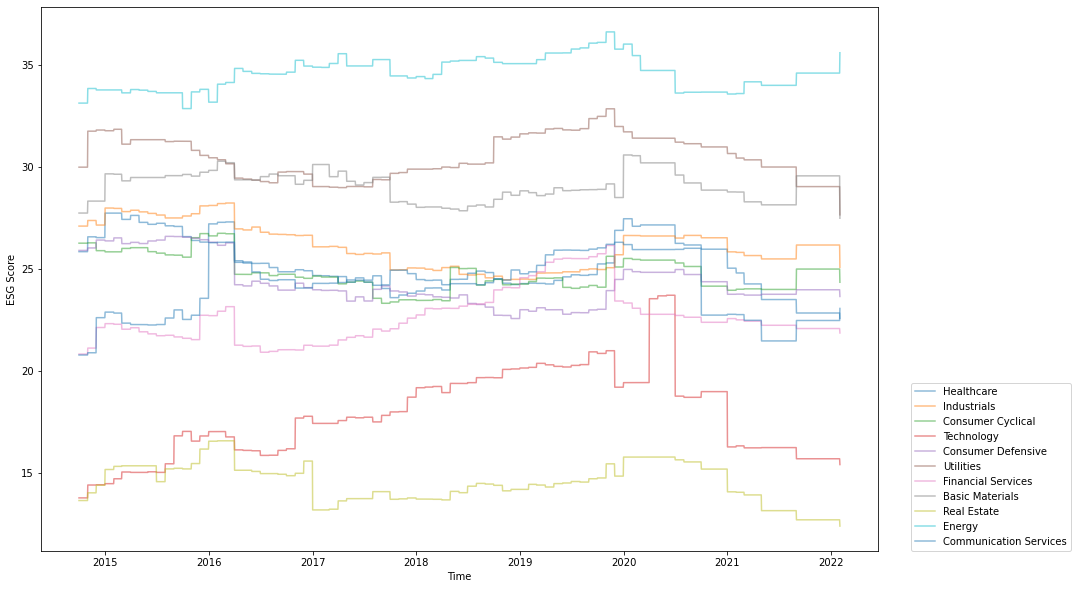

In [151]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
for sector in index_dict.columns:

    y = index_dict[sector].fillna(method='ffill')

    out = ax.plot(index_dict.index, y, alpha = 0.5, label = sector)
    # legend_ticks.append(sector)

ax.legend(loc=(1.04,0))
ax.set_xlabel("Time")
ax.set_ylabel("ESG Score")

Take Difference of sectors

In [131]:
index_dict_diff = []
for i in range(index_dict.shape[1]):
    diff = index_dict.iloc[:,i].dropna().diff().iloc[1:]
    index_dict_diff.append(diff)

index_dict_diff = pd.merge(pd.DataFrame(index = index_dict.index[index_dict.index >= datetime.date(2014,11, 1)])
,pd.concat(index_dict_diff, axis = 1), left_index = True, right_index = True, how = 'left')

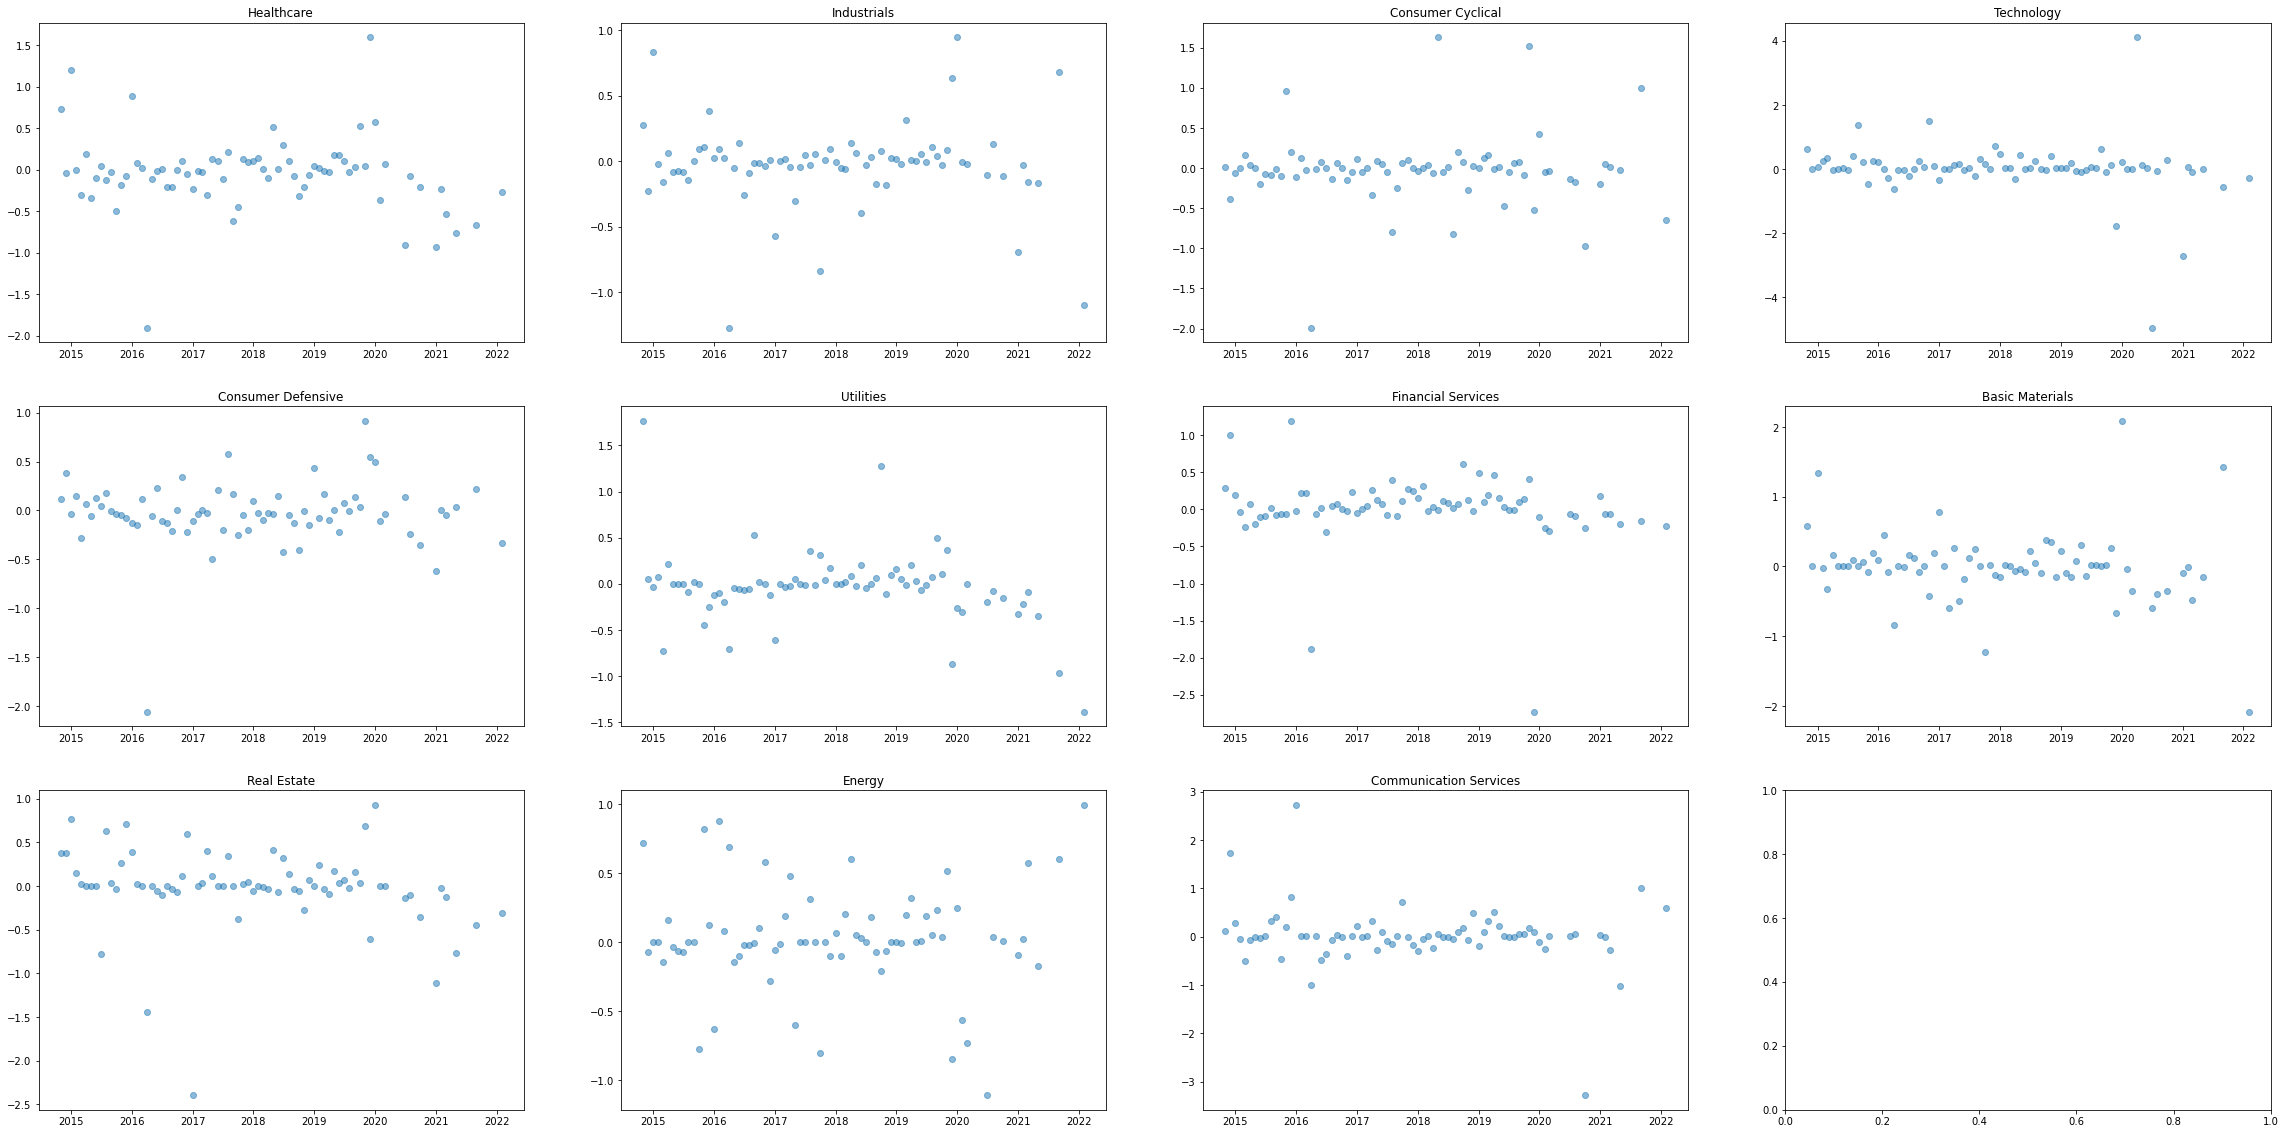

In [132]:


fig, ax = plt.subplots( 3, 4, figsize = (40,20))
for idx, sector in enumerate(index_dict_diff.columns):

    j = idx % 4
    i = int(np.floor(idx/4))

    y = index_dict_diff[sector]

    ax[i,j].scatter(index_dict_diff.index, y, alpha = 0.5, label = sector)
    ax[i,j].set_title(sector)



Looks better than individual stocks

In [150]:
index_dict_diff.to_pickle('../Yahoo/sector_index.pkl')
index_dict.to_pickle('../Yahoo/sector_index_no_diff.pkl')

with pd.ExcelWriter('../Yahoo/ESG_sector.xlsx') as writer:  

    index_dict_diff.to_excel(writer, sheet_name='Differenced')
    index_dict.to_excel(writer, sheet_name='No_diff')

# Industrial sector industry

No esg data on companies in industry Rental & Leasing Services
No esg data on companies in industry Tools & Accessories
No esg data on companies in industry Trucking
No esg data on companies in industry Waste Management


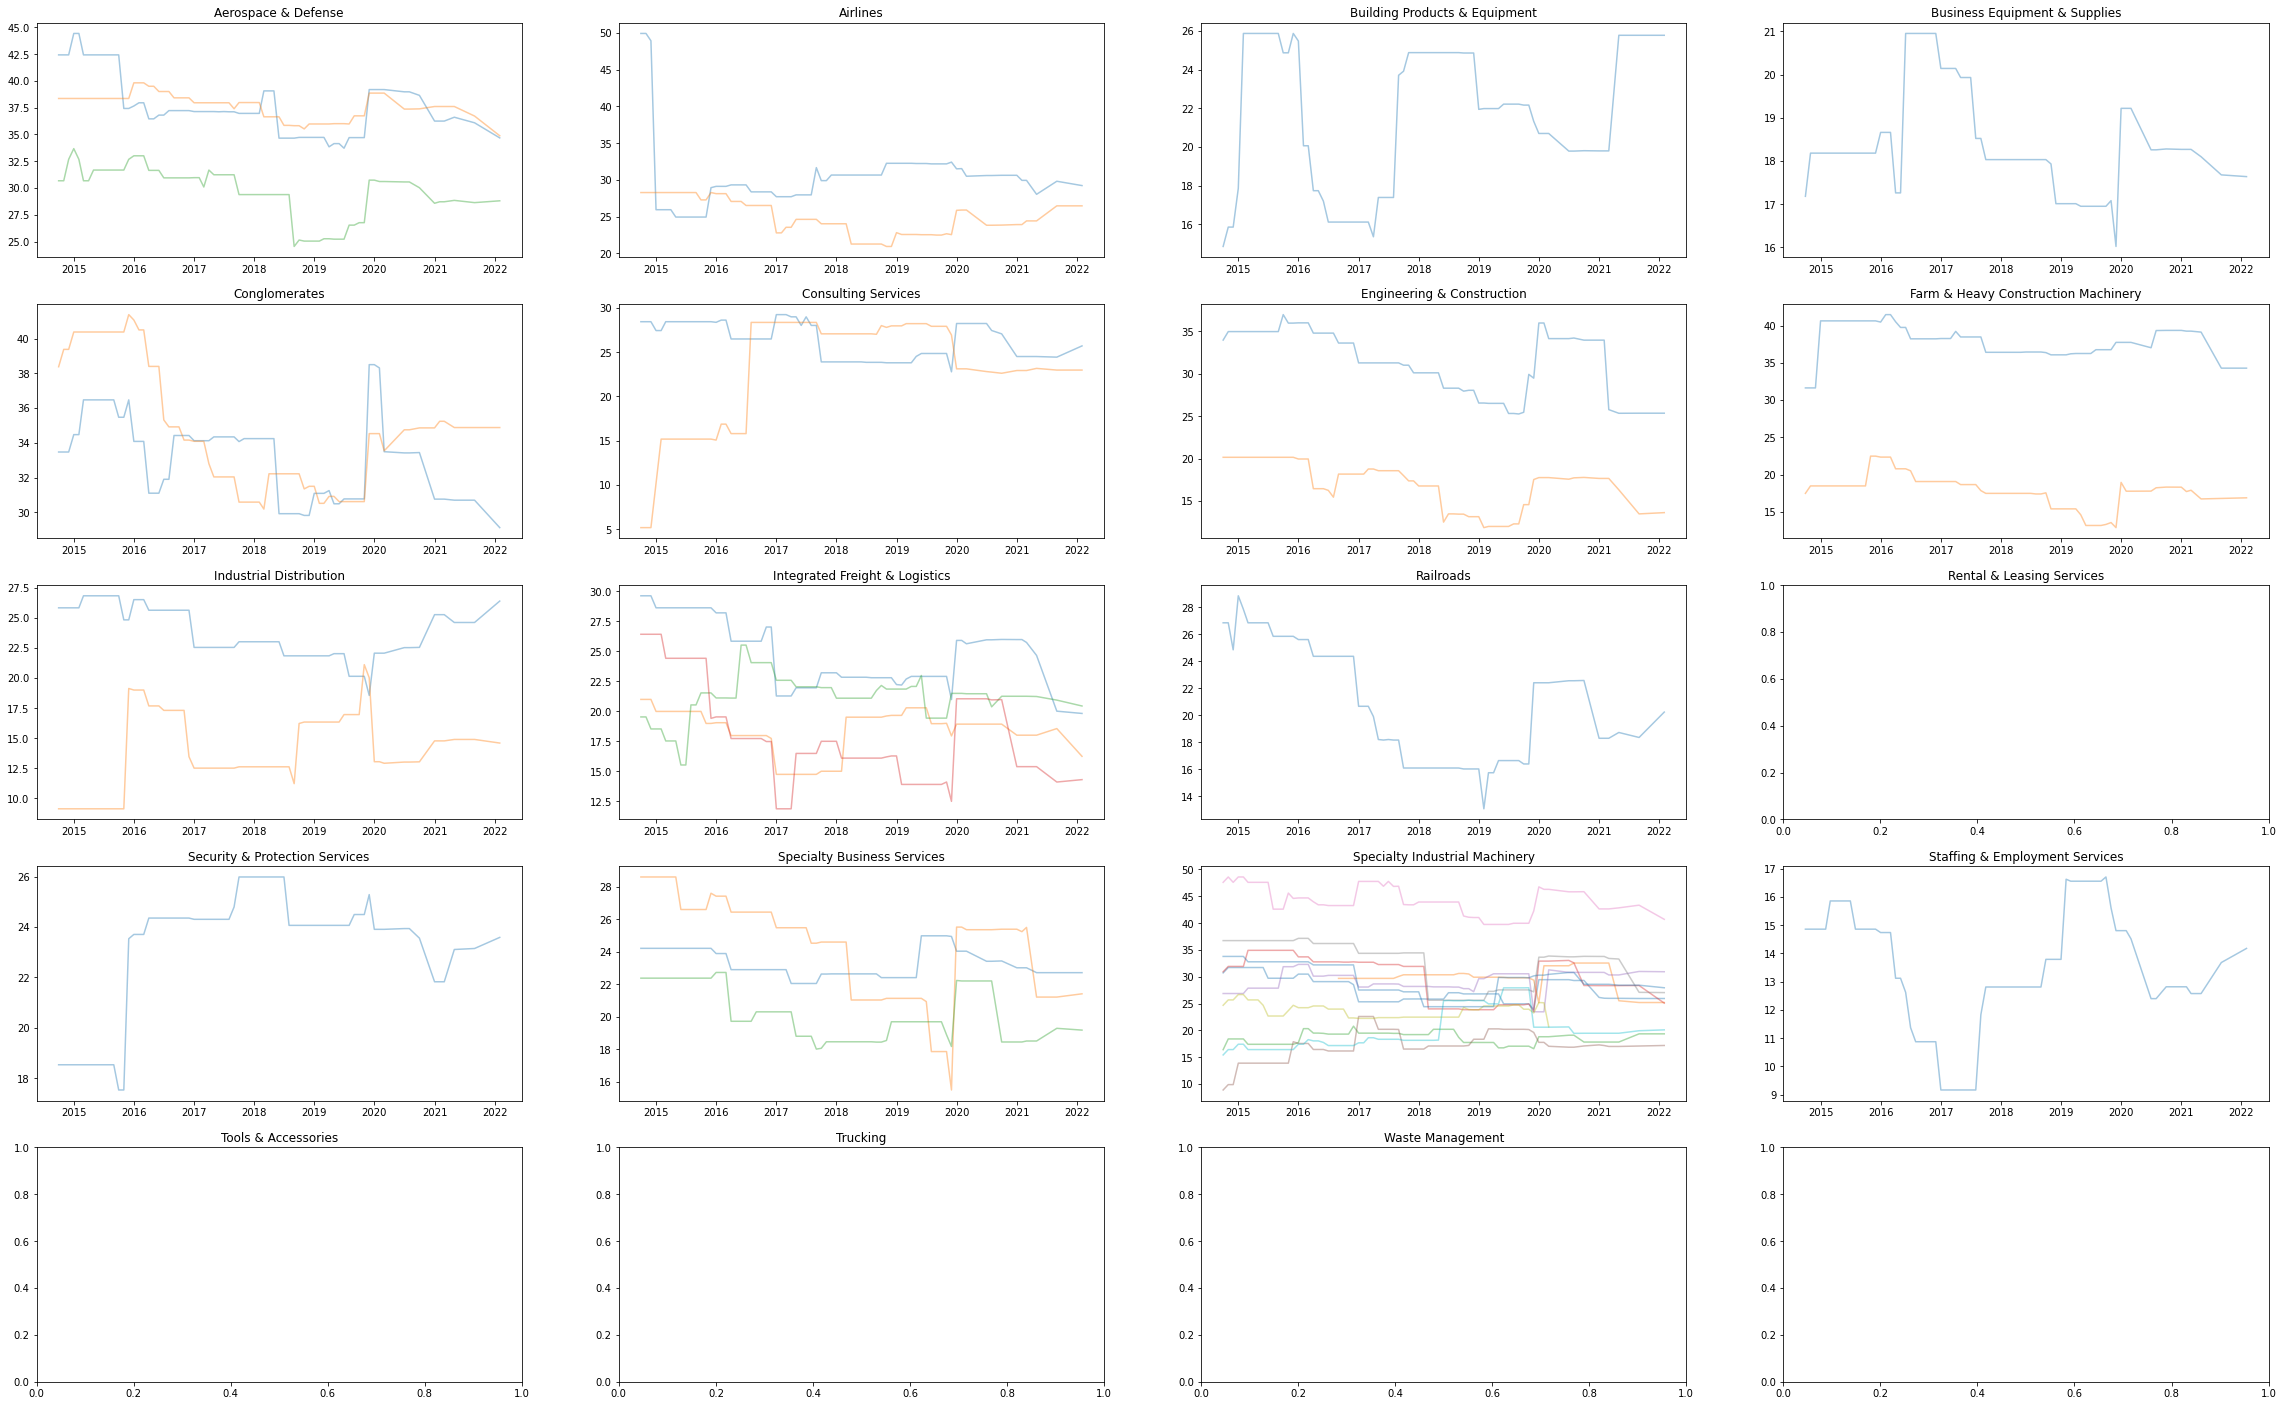

In [41]:
plot_esg_industry('Industrials', asset_profiles, esg_pivot_shifted)

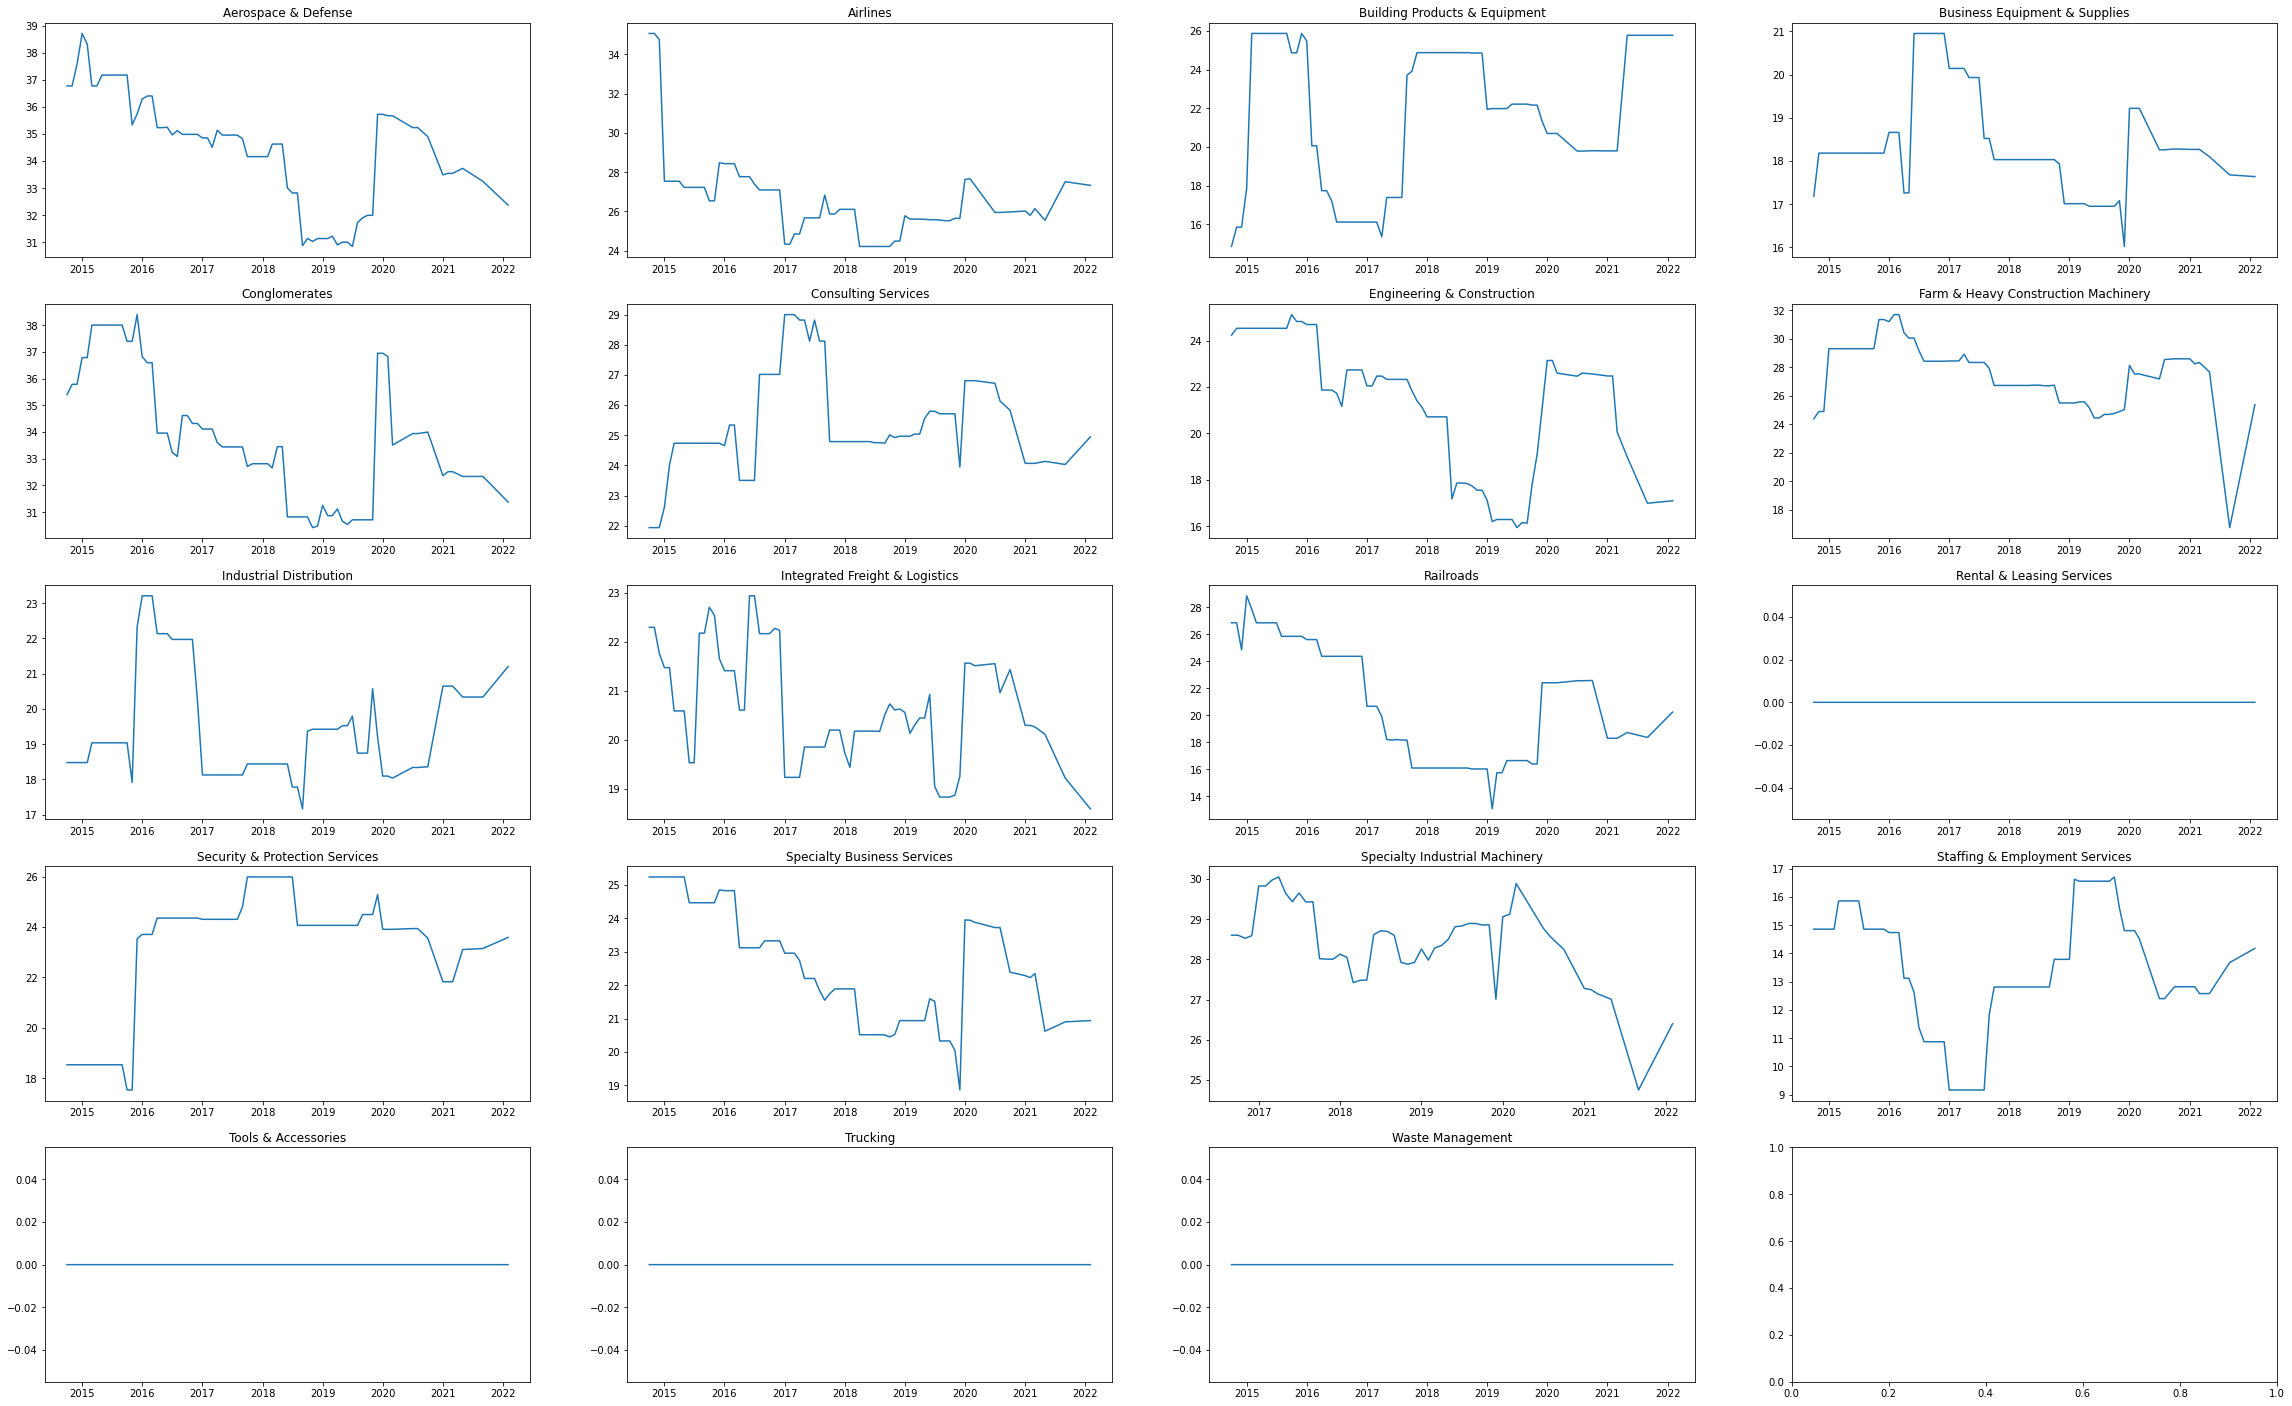

In [44]:
industrial_sector = index_esg_industry('Industrials', asset_profiles, esg_pivot_shifted, marketcap)
k = industrial_sector.shape[1]
fig, axs = plt.subplots( int(k/4)+1 , 4, figsize = (40 ,5*(int(k/4)+1)))

for idx, industry in enumerate(industrial_sector.columns):

    j = idx % 4
    i = int(np.floor(idx/4))
    y = industrial_sector[industry]
    axs[i,j].plot(y[np.isfinite(y)])
    axs[i,j].set_title(industry)
        

    


# Energy

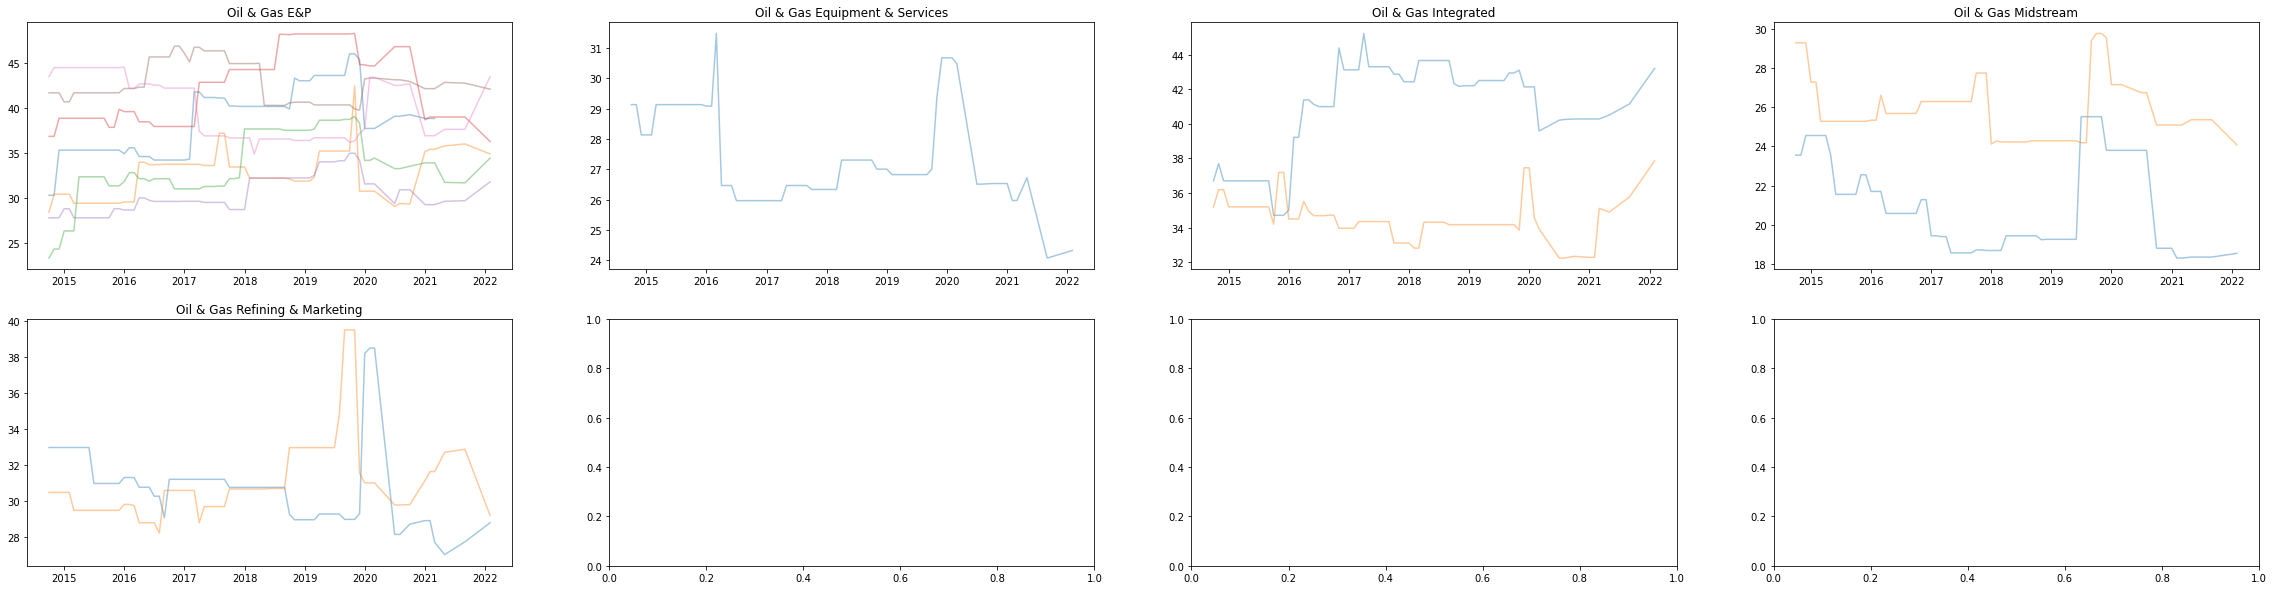

In [119]:
plot_esg_industry('Energy', asset_profiles, esg_pivot_shifted)

# Utilities

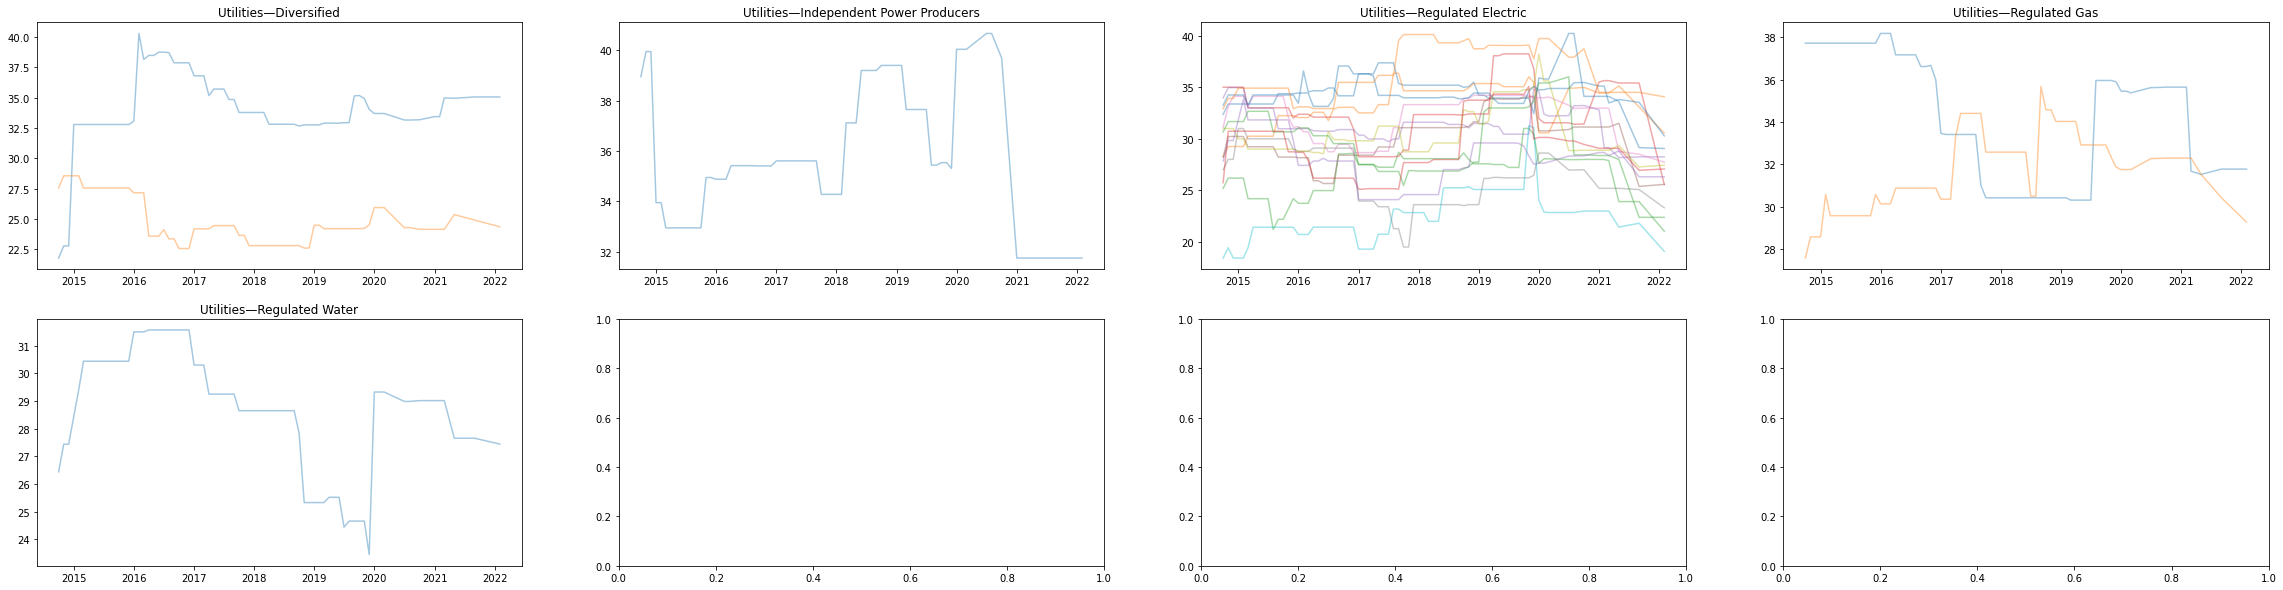

In [121]:
plot_esg_industry('Utilities', asset_profiles, esg_pivot_shifted)

# Basic Materials

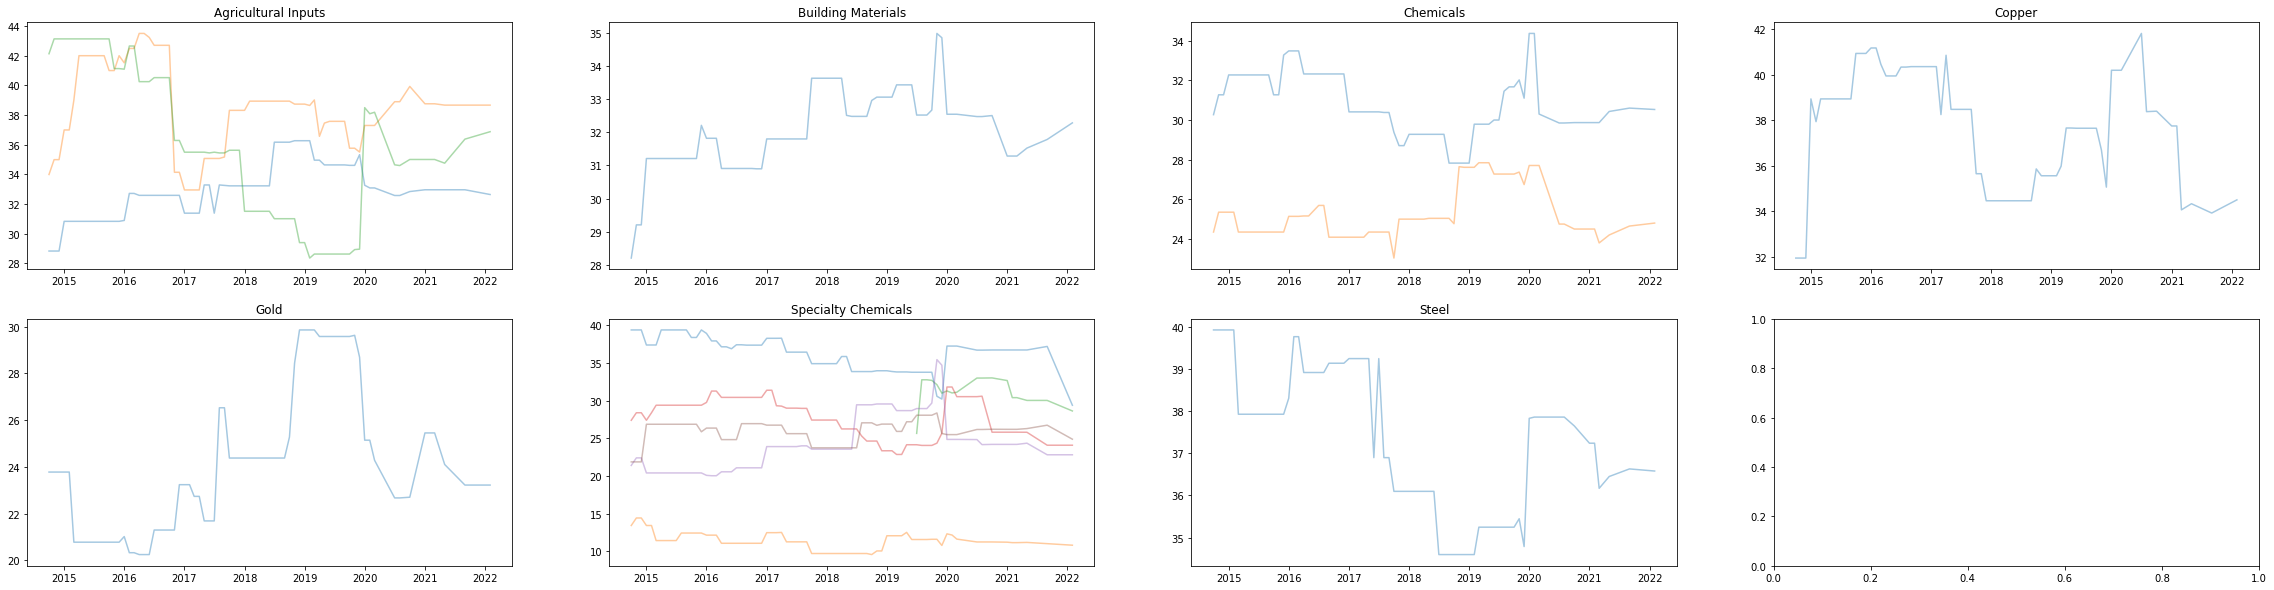

In [122]:
plot_esg_industry('Basic Materials', asset_profiles, esg_pivot_shifted)

# Financial Services

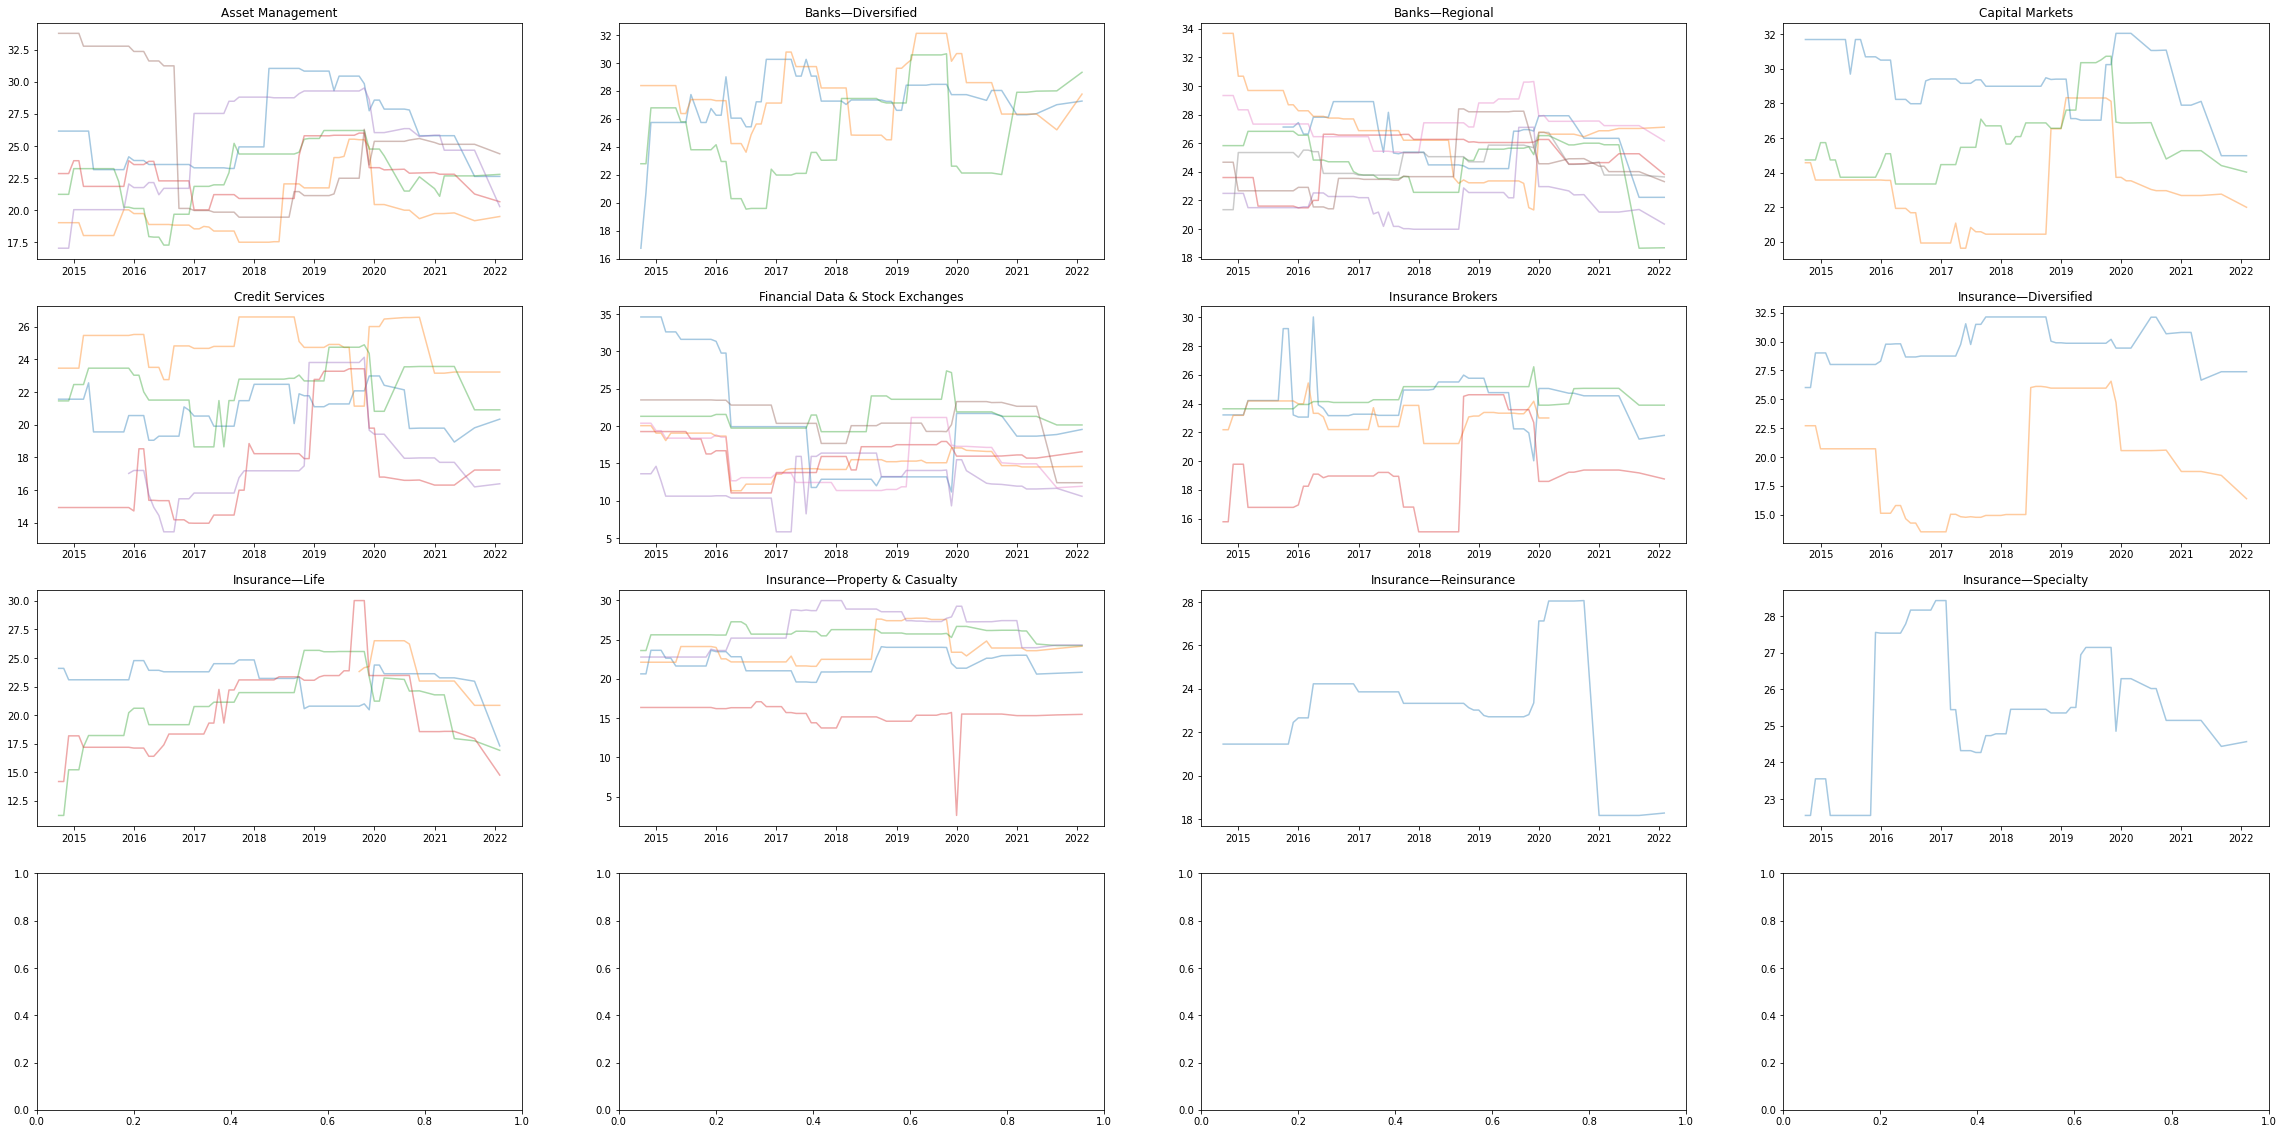

In [123]:
plot_esg_industry('Financial Services', asset_profiles, esg_pivot_shifted)

# Consumer Defensive

No esg data on companies in industry Food Distribution


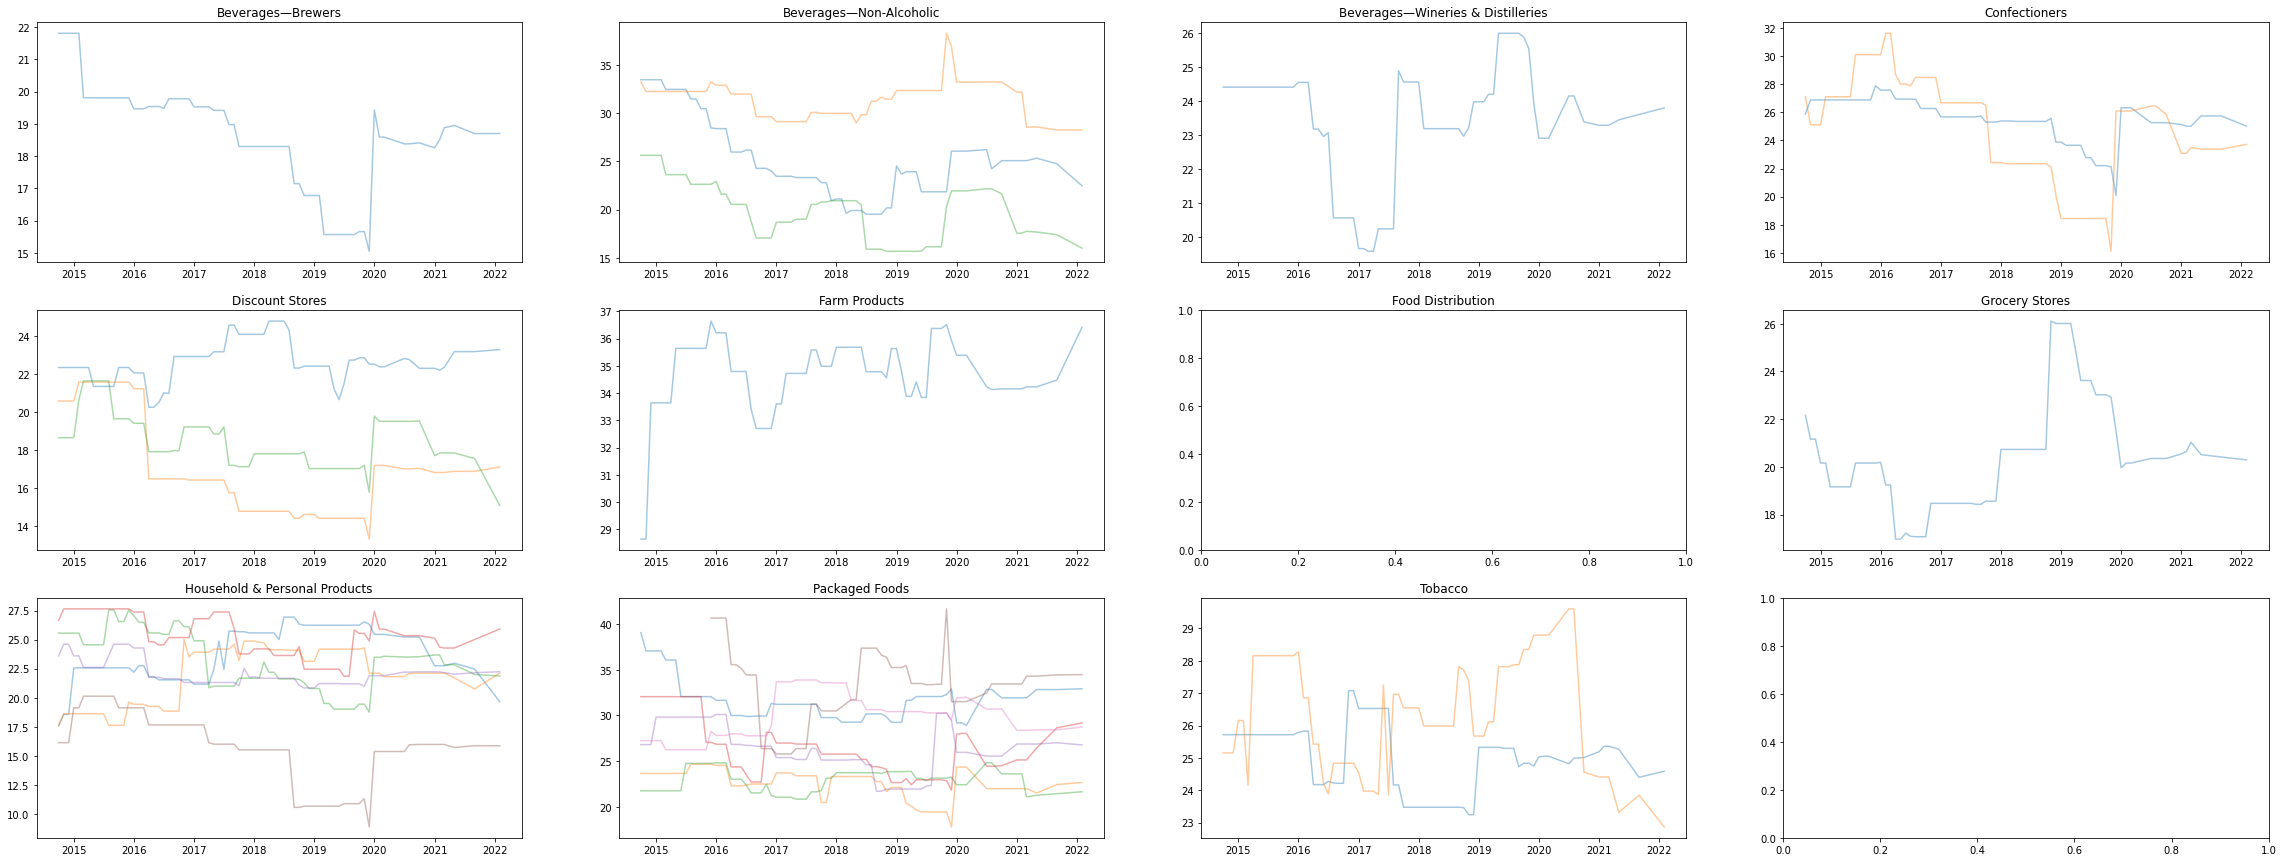

In [124]:
plot_esg_industry('Consumer Defensive', asset_profiles, esg_pivot_shifted)

# Consumer Cyclical

No esg data on companies in industry Apparel Manufacturing
No esg data on companies in industry Apparel Retail
No esg data on companies in industry Luxury Goods
No esg data on companies in industry Personal Services


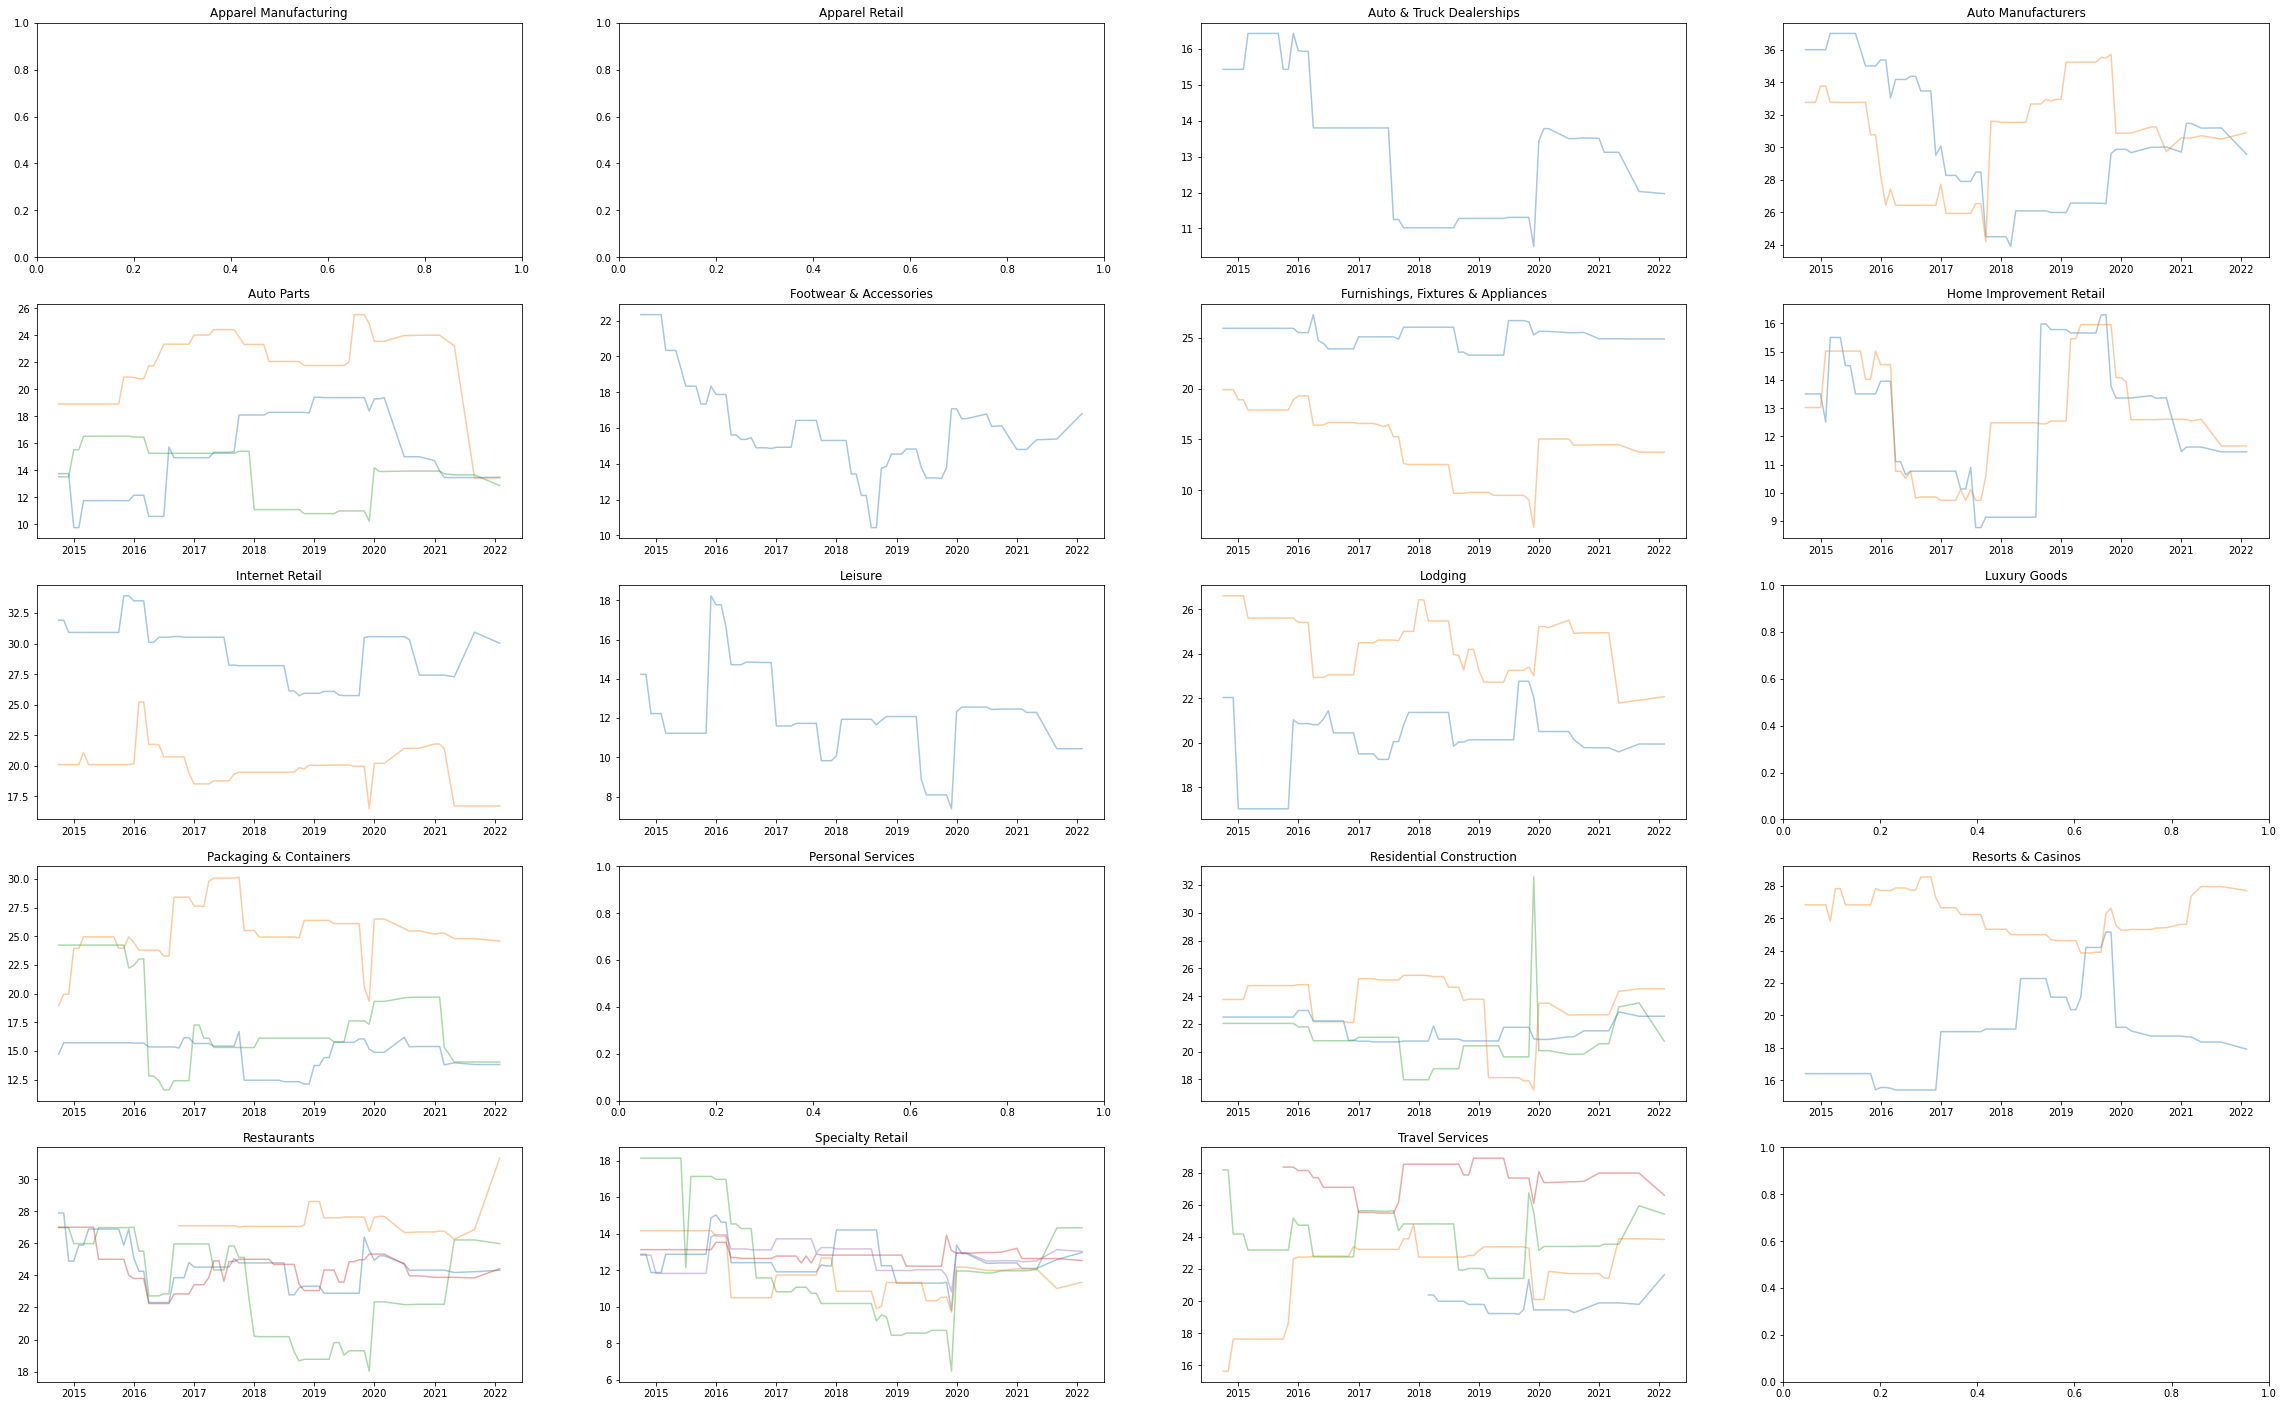

In [126]:
plot_esg_industry('Consumer Cyclical', asset_profiles, esg_pivot_shifted)

# Technology

No esg data on companies in industry Solar


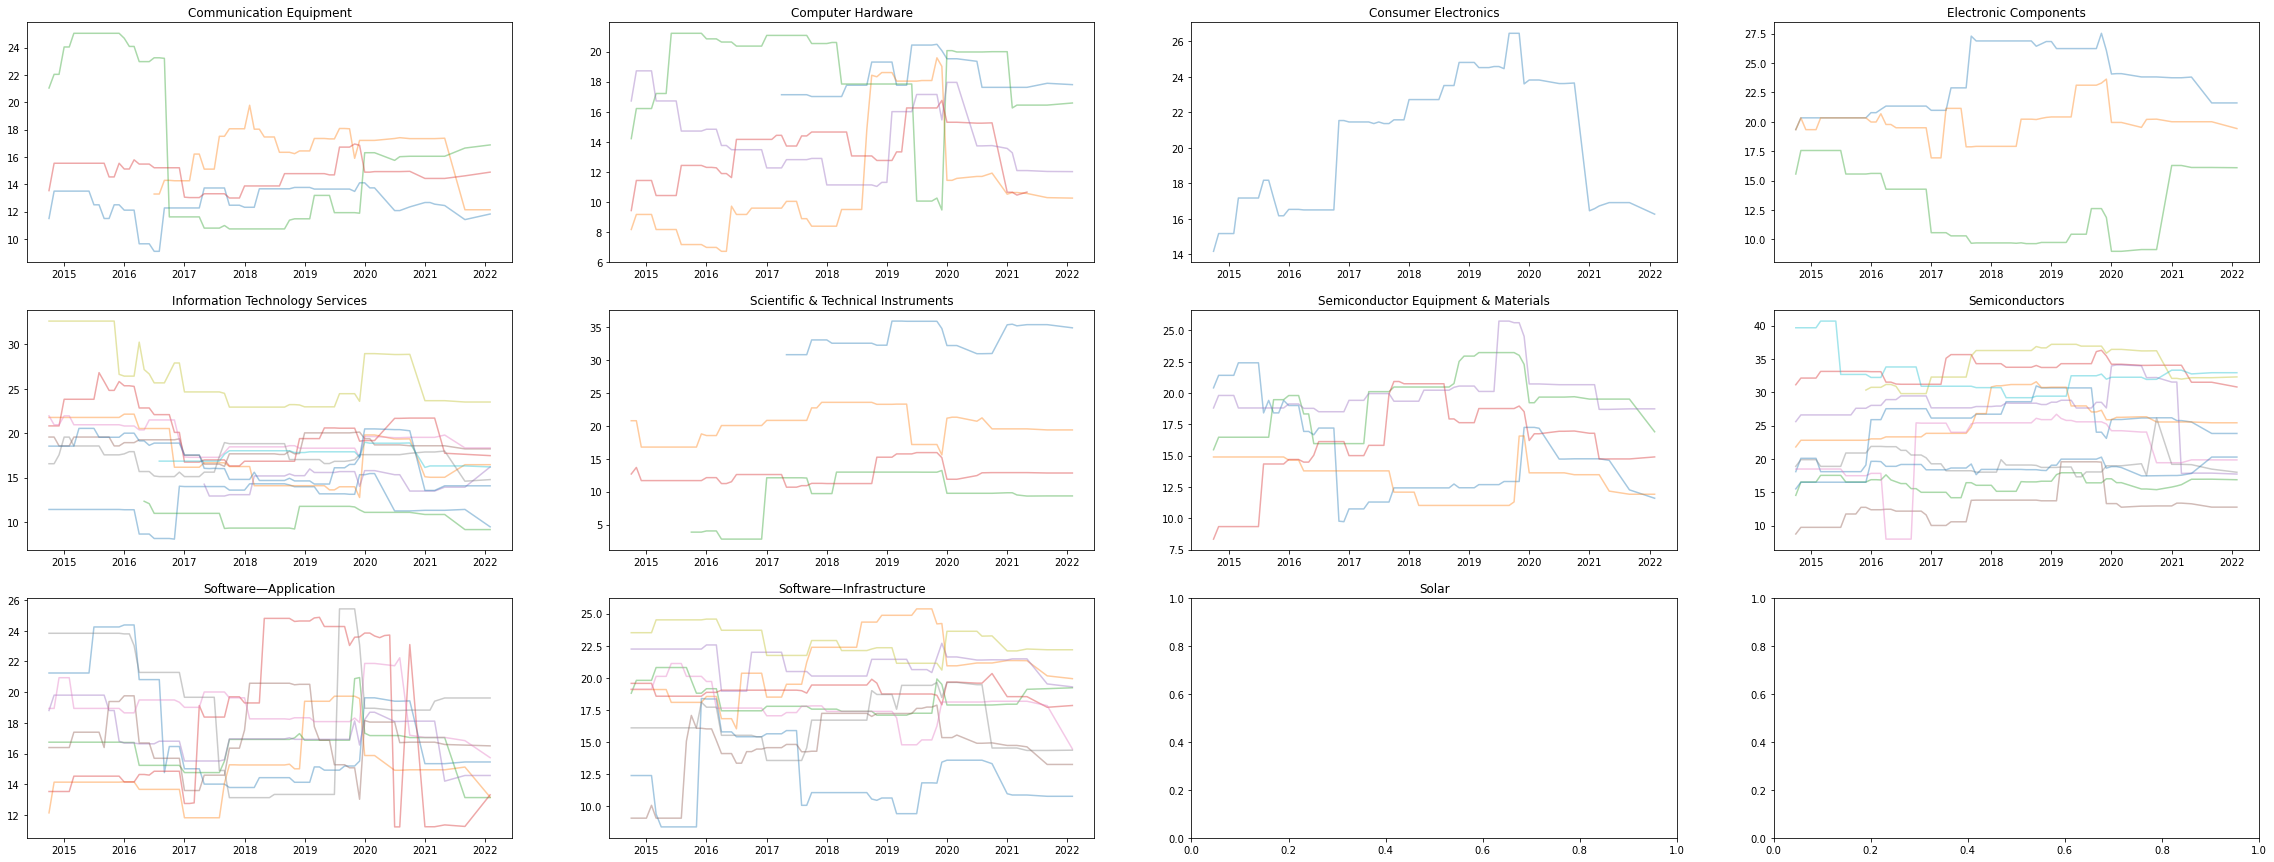

In [84]:
plot_esg_industry('Technology', asset_profiles, esg_pivot_shifted)

In [120]:
sector_classification.keys()

dict_keys(['Healthcare', 'Industrials', 'Consumer Cyclical', 'Technology', 'Consumer Defensive', 'Utilities', 'Financial Services', 'Basic Materials', 'Real Estate', 'Energy', 'Communication Services'])